In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from dm_tools import data_prep

df = data_prep()
rs = 10
y=df['TargetB']
x = df.drop(['TargetB'], axis=1)
x_mat = x.values
xtr, xtst, ytr, ytst = train_test_split(x_mat, y, test_size=0.3, stratify=y, random_state=rs)

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print("Before scaling\n-------------")
for i in range(5):
    col = xtr[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i, min(col), max(col), np.mean(col), np.std(col)))

xtr = scaler.fit_transform(xtr, ytr)
xtst = scaler.transform(xtst)
print("After scaling\n-------------")
for i in range(5):
    col = xtr[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i, min(col), max(col), np.mean(col), np.std(col)))

Before scaling
-------------
Variable #0: min 0.0, max 13.0, mean 3.20 and std dev 2.13
Variable #1: min 1.0, max 89.0, mean 10.50 and std dev 8.95
Variable #2: min 0.0, max 9.0, mean 1.86 and std dev 1.59
Variable #3: min 0.0, max 41.0, mean 5.58 and std dev 4.73
Variable #4: min 0.0, max 450.0, mean 15.97 and std dev 12.07
After scaling
-------------
Variable #0: min -1.505311488472091, max 4.600729037733905, mean -0.00 and std dev 1.00
Variable #1: min -1.0623391496250907, max 8.7746107562059, mean -0.00 and std dev 1.00
Variable #2: min -1.1659811623481273, max 4.487429288703341, mean -0.00 and std dev 1.00
Variable #3: min -1.1795617205202689, max 7.485041166941727, mean -0.00 and std dev 1.00
Variable #4: min -1.3225650969557856, max 35.95505089608766, mean 0.00 and std dev 1.00


In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=rs)
model.fit(xtr, ytr)
print("Train accuracy:", model.score(xtr, ytr))
print("Test accuracy:", model.score(xtst, ytst))
y_pred = model.predict(xtst)
print(classification_report(ytst, y_pred))

Train accuracy: 0.5935103244837758
Test accuracy: 0.5622849277357193
             precision    recall  f1-score   support

          0       0.56      0.57      0.57      1453
          1       0.56      0.55      0.56      1453

avg / total       0.56      0.56      0.56      2906



In [4]:
feature_names = x.columns
coef = model.coef_[0]
coef = coef[:20]
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
for i in indices[:20]:
    print(feature_names[i], ':', coef[i])

PromCntCardAll : -0.43851255885666734
GiftTimeFirst : 0.2804476485131589
PromCntAll : 0.19782012719097772
GiftTimeLast : -0.16833272253227194
PromCnt12 : -0.1398648362290369
DemMedHomeValue : 0.12585620935682737
StatusCatStarAll : 0.11004787143409926
GiftCntCard36 : 0.09602623607589704
PromCntCard36 : 0.09494982420780446
GiftCnt36 : 0.08552948189048604
GiftCntCardAll : -0.0768268037209868
GiftAvgAll : 0.07375646123932444
GiftAvgCard36 : -0.05930713749983856
GiftCntAll : 0.05729057652765238
DemAge : 0.055101140408408245
PromCnt36 : 0.050613998292421865
GiftAvgLast : -0.0503317638336539
PromCntCard12 : 0.047784191449562745
GiftAvg36 : -0.03994299820131242
DemHomeOwner : 0.027000444463941384


In [5]:
params = {'C': [pow(10,x) for x in range(-6,4)]}
cv=GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),cv=10,n_jobs=-1)
cv.fit(xtr, ytr)

print("Train accuracy:", cv.score(xtr, ytr))
print("Test accuracy:", cv.score(xtst, ytst))
y_pred = cv.predict(xtst)
print(classification_report(ytst, y_pred))
print(cv.best_params_)


Train accuracy: 0.5951327433628318
Test accuracy: 0.5653819683413627
             precision    recall  f1-score   support

          0       0.56      0.59      0.57      1453
          1       0.57      0.55      0.56      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.001}


In [6]:
# Input transformation and dim reduction
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def plot_skewed_columns(df):
    f, axes = plt.subplots(2, 4, figsize=(10,10), sharex=False)
    
    sns.distplot(df['GiftAvg36'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['GiftAvgAll'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['GiftAvgCard36'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['GiftAvgLast'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['GiftCnt36'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['GiftCntAll'].dropna(), hist=False, ax=axes[0,3])
    sns.distplot(df['GiftCntCard36'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['GiftCntCardAll'].dropna(), hist=False, ax=axes[1,3])

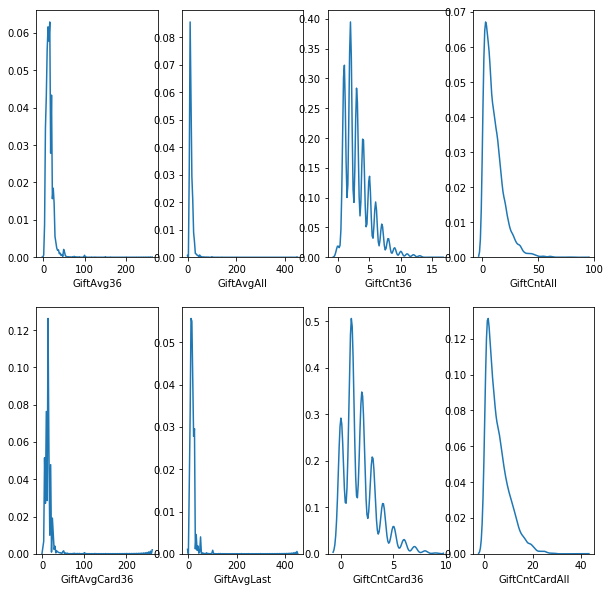

In [8]:
plot_skewed_columns(df)

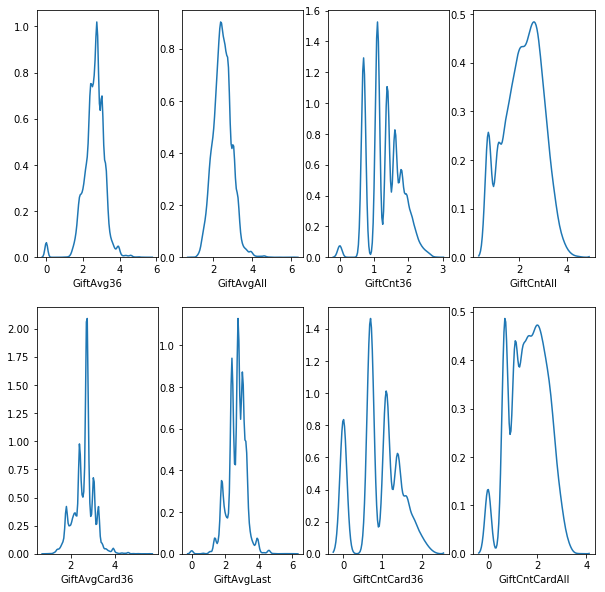

In [9]:
cols_transform = ['GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36', 'GiftAvgLast','GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll']
df_log = df.copy()

for col in cols_transform:
    df_log[col] = df_log[col].apply(lambda x:x+1) #remove nan values, make the base level 1 atleast for scaling
    df_log[col] = df_log[col].apply(np.log)
    
plot_skewed_columns(df_log)

In [10]:
#Create train test split on log
ylog = df_log['TargetB']
xlog = df_log.drop(['TargetB'], axis=1)
xlog_mat = xlog.values
xtr_log, xtst_log, ytr_log, ytst_log = train_test_split(xlog_mat, ylog, test_size=0.3, stratify=ylog, random_state=rs)

In [11]:
#Standardise
scalerlog = StandardScaler()
xtr_log = scalerlog.fit_transform(xtr_log, ytr_log)
xtst_log = scalerlog.fit_transform(xtst_log, ytst_log)

In [12]:
params = {'C': [pow(10, x) for x in range(-6,4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(xtr_log, ytr_log)

print('Train accuracy:', cv.score(xtr_log, ytr_log))
print('Test accuracy:', cv.score(xtst_log, ytst_log))

print(classification_report(ytst_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.593952802359882
Test accuracy: 0.5681348933241569
             precision    recall  f1-score   support

          0       0.56      0.59      0.57      1453
          1       0.57      0.55      0.56      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.001}


In [13]:
from sklearn.feature_selection import RFECV
#10 fold validation on logistic regression
rfe = RFECV(estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe.fit(xtr, ytr)
print("Original feature set", xtr.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 85
Number of features after elimination 40


In [14]:
xtr_sel = rfe.transform(xtr)
xtst_sel = rfe.transform(xtst)

In [15]:
cv.fit(xtr_sel, ytr)
print("Train accuracy:", cv.score(xtr_sel, ytr))
print("Test accuracy:", cv.score(xtst_sel, ytst))

y_pred = cv.predict(xtst_sel)
print(classification_report(ytst, y_pred))
print(cv.best_params_)

Train accuracy: 0.5935103244837758
Test accuracy: 0.5688231245698555
             precision    recall  f1-score   support

          0       0.57      0.58      0.57      1453
          1       0.57      0.56      0.56      1453

avg / total       0.57      0.57      0.57      2906

{'C': 100}


In [19]:
from sklearn.tree import DecisionTreeClassifier
params = {'criterion': ['gini', 'entropy'],
         'max_depth': range(2,7),
         'min_samples_leaf': range(20,60,10)}
cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(), cv=10, n_jobs=-1)
cv.fit(xtr_log, ytr_log)
print(cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50}


In [20]:
from dm_tools import analyse_feature_importance
analyse_feature_importance(cv.best_estimator_, xlog.columns)

GiftCnt36 : 0.32372028991803176
DemMedHomeValue : 0.16870399488848986
GiftAvgLast : 0.13715027943543454
GiftTimeLast : 0.07216895789175108
StatusCatStarAll : 0.04624807594062364
GiftCntAll : 0.04526431066083868
GiftCntCardAll : 0.04444007634482767
PromCntCardAll : 0.038352830083886735
DemPctVeterans : 0.029606101805632952
PromCnt36 : 0.018147095366402428
GiftAvgAll : 0.017372969310631516
StatusCat96NK_A : 0.016862957062736873
GiftTimeFirst : 0.014129096904096769
GiftAvgCard36 : 0.013209693354314394
PromCntCard12 : 0.00872994822258077
PromCnt12 : 0.005893322809720318
DemCluster_13 : 0.0
DemCluster_10 : 0.0
DemCluster_11 : 0.0
DemCluster_12 : 0.0


In [22]:
from sklearn.feature_selection import SelectFromModel
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
xtr_selmodel = selectmodel.transform(xtr_log)
xtst_selmodel = selectmodel.transform(xtst_log)
print(xtr_selmodel.shape)

(6780, 14)


In [25]:
params = {'C': [pow(10,x) for x in range(-6, 4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(), cv=10, n_jobs=-1)
cv.fit(xtr_selmodel, ytr_log)
print("Train accuracy:", cv.score(xtr_selmodel, ytr_log))
print("Test accuracy:", cv.score(xtst_selmodel, ytst_log))

y_pred = cv.predict(xtst_selmodel)
print(classification_report(ytst_log, y_pred))
print(cv.best_params_)

Train accuracy: 0.5817109144542773
Test accuracy: 0.5698554714384033
             precision    recall  f1-score   support

          0       0.57      0.58      0.57      1453
          1       0.57      0.56      0.57      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.01}
